# Data Science Sample

A challenge and opportunity of this role is that you'll have to work across a variety of disease areas and data types so while this may not be your direct area of expertise you should be able to handle new requests and work through a set of explorations around it.  In this instance, we will give you a small sample type of one problem: prediction of clinically significant events using machine learning. This is also a way for you to show us your preferred style of:

1. writing code in a way that is easy to understand and self-explanatory
2. documentation: ie comments, descriptions of inputs and outputs within the function, etc
3. data science: data visualizations, statistics, machine learning theory
4. writing efficient code: modularity, parallelization
5. communicating technical information and concepts
6. resourcefulness and self teaching

Part of our follow up interview is to have you teach us how to reproduce and understand your work in this notebook. Please do not spend more than 3 hours on this coding challenge.

Feel free to install/import other python packages, here are some basic ones to get started.

In [1]:
import os, sys, time, re, random, math, json
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
print(sys.version)

3.10.6 (main, Aug 30 2022, 05:11:14) [Clang 13.0.0 (clang-1300.0.29.30)]


## Load the Sample Dataset

Along with this jupyter notebook you should have received one other file called `berlin_ards.json` (Please unzip if you receive a zip file). It is a json file containing the data that we will be working with for this project. Load it with the cell below

In [2]:
with open('berlin_ards.json') as json_file:
    berlin_ards = json.load(json_file)

In [3]:
len(berlin_ards.keys())

8709

## Introduction to the Sample Dataset

This sample dataset is a subset taken from a freely accessible critical care database. `berlin_ards` above is a dictionary of patient encounters. An encounter is one hospitalization. One patient can have multiple admissions to the hospital. Each admission would have a unique encounter_ID. In this dataset the times have been modified but the time intervals are real. Run the cells below to get acquainted.

In [4]:
keys = list(berlin_ards.keys())
num_encs = len(keys)
print("There are {} patient encounters in this dataset".format(num_encs))

There are 8709 patient encounters in this dataset


In [5]:
print(berlin_ards[keys[1]])

{'Info': {'age': 80.0, 'gender': 'F', 'weight': nan, 'subject_id': '76603', 'is_in_hospital_death': True, 'is_Berlin_ARDS': False, 'first_measurement_time': '2127-03-03T15:45:00', 'is_Berlin_time': '2127-03-03T17:27:00', 'last_measurement_time': '2127-03-03T20:30:00'}, 'feature_matrix_row_names': ['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets'], 'feature_sampling_interval_minutes': 30, 'feature_matrix': [[nan, 112.0, 113.0, 113.0, 113.0, 75.0, 75.0, 125.0, 125.0, 112.0], [nan, 73.0, 75.0, 75.0, 75.0, 59.0, 59.0, 81.0, 81.0, 79.0], [nan, 123.0, 115.0, 116.0, 116.0, 106.0, 106.0, 101.0, 101.0, 107.0], [nan, nan, nan, nan, nan, nan, 34.6, 34.6, 34.6, 34.0], [nan, 18.0, 20.0, 20.0, 20.0, 21.0, 21.0, 20.0, 20.0, 21.0], [nan, nan, nan, nan, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0], [2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2], [12.4, 12.4, 12.4, 12.4, 12.4, 12.4, 12.4, 12.4, 12.4, 12.4], [127.0, 127.0, 127.0, 127.0, 127.0, 127.0, 127.0, 127.0, 127.0,

In [6]:
print(berlin_ards[keys[0]].keys())

dict_keys(['Info', 'feature_matrix_row_names', 'feature_sampling_interval_minutes', 'feature_matrix'])


In [7]:
print("{} is an example of an encounter ID".format(keys[0]))

200021 is an example of an encounter ID


plug the encounter ID into the dictionary to see information about this patient's encounter

here is some basic information about this hospitalization and all the keys to the other types of data for this encounter

In [8]:
enc = berlin_ards[keys[0]]
print('')
print(enc['Info'])
enc.keys()


{'age': 60.0, 'gender': 'M', 'weight': 82.6, 'subject_id': '61691', 'is_in_hospital_death': False, 'is_Berlin_ARDS': False, 'first_measurement_time': '2114-12-26T20:40:00', 'is_Berlin_time': '2114-12-26T21:23:00', 'last_measurement_time': '2114-12-27T22:00:00'}


dict_keys(['Info', 'feature_matrix_row_names', 'feature_sampling_interval_minutes', 'feature_matrix'])

Most of this you will have to figure out for yourself, but lets go over some special data components

First, we have given you a feature matrix of time series features where each row is a different vital sign or lab measurement and each column is a different timestep starting with column 0 = time zero.  

As an example, here are the first 24 hours of oxygen saturation (SpO2) measurements. The first SpO2 measurement was made 60 minutes into the stay, which is why the first 2 columns are not a number

In [9]:
print(enc['feature_matrix_row_names'])
period = enc['feature_sampling_interval_minutes']
print('number of features', len(enc['feature_matrix_row_names']))
print('minutes between timesteps', period)
feature_index = 5
print(enc['feature_matrix_row_names'][feature_index])
feature_matrix = np.array(enc['feature_matrix'])
print(feature_matrix[feature_index,:int(24*60/period)])
print(feature_matrix.shape)

['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']
number of features 9
minutes between timesteps 30
SpO2
[nan nan 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 98. 98. 96. 96. 94.
 94. 97. 97. 96. 96. 96. 96. 94. 94. 94. 94. 94.]
(9, 51)


### Sanity Check

The length of stay should be within one period of the amount of time represented by the feature matrix

In [10]:
enc['Info']['first_measurement_time']

'2114-12-26T20:40:00'

In [11]:
start_time = datetime.strptime(enc['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
stop_time = datetime.strptime(enc['Info']['last_measurement_time'], '%Y-%m-%dT%H:%M:%S')

lenofstay_mins = (stop_time - start_time).total_seconds()/60
print(int(lenofstay_mins/60), 'hours', feature_matrix.shape[1]*period/60, 'hours')

25 hours 25.5 hours


In [16]:
def plot_feature_distribution_all_patients(all_feature_matrices, feature_names, feature_sampling_interval_minutes):
    num_features = all_feature_matrices.shape[1]
    num_rows = int(np.ceil(num_features / 3))
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    fig.suptitle('Feature Distributions for all Patients', fontsize=16)

    for i in range(num_features):
        row = i // 3
        col = i % 3
        feature_values = all_feature_matrices[:, i, :].flatten()
        feature_values = feature_values[~np.isnan(feature_values)]

        ax = axes[row, col]
        ax.hist(feature_values, bins=50, density=True, alpha=0.7, color='skyblue')
        ax.set_title(feature_names[i], fontsize=14)
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.grid(True)

    # Remove any empty subplots
    if num_features % 3 != 0:
        for i in range(num_features % 3, 3):
            fig.delaxes(axes[-1, i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def generate_feature_statistics_all_patients(all_feature_matrices, feature_names, feature_sampling_interval_minutes):
    # Create a DataFrame to store the statistics
    statistics_df = pd.DataFrame(index=feature_names, columns=['Mean', 'Median', 'Std Dev', 'Min', 'Max', '25th Percentile', '75th Percentile'])

    # Loop through each feature
    for i, feature_name in enumerate(feature_names):
        feature_values = all_feature_matrices[:, i, :].flatten()
        feature_values = feature_values[~np.isnan(feature_values)]

        # Calculate the statistics
        mean = np.nanmean(feature_values)
        median = np.nanmedian(feature_values)
        std_dev = np.nanstd(feature_values)
        minimum = np.nanmin(feature_values)
        maximum = np.nanmax(feature_values)
        percentile_25 = np.nanpercentile(feature_values, 25)
        percentile_75 = np.nanpercentile(feature_values, 75)

        # Store the statistics in the DataFrame
        statistics_df.loc[feature_name] = [mean, median, std_dev, minimum, maximum, percentile_25, percentile_75]

    return statistics_df

In [17]:
#### Reorganize all the values from the raw data.

# Create lists to store information for all patients
all_ages = []
all_weights = []
all_genders = []
all_is_in_hospital = []
all_is_berlin_ards = []
all_feature_matrices = []
all_time_intervals = []
all_len_of_stay_mins = []

# Loop through all patients and extract their information
for patient_id in berlin_ards.keys():
    # Extract patient data
    patient_data = berlin_ards[patient_id]['Info']
    feature_matrix = berlin_ards[patient_id]['feature_matrix']
    
    # Extract age, weight, gender, and is_in_hospital for the patient
    age = patient_data['age']
    weight = patient_data['weight']
    gender = patient_data['gender']
    is_in_hospital = patient_data['is_in_hospital_death']
    is_berlin_ards = patient_data['is_Berlin_ARDS']

    
    # Calculate time interval and length of stay
    start_time = datetime.strptime(patient_data['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
    stop_time = datetime.strptime(patient_data['last_measurement_time'], '%Y-%m-%dT%H:%M:%S')
    time_interval = berlin_ards[patient_id]['feature_sampling_interval_minutes']
    len_of_stay_mins = (stop_time - start_time).total_seconds() / 60
    
    # Append the information to the respective lists
    all_ages.append(age)
    all_weights.append(weight)
    all_genders.append(gender)
    all_is_in_hospital.append(is_in_hospital)
    all_is_berlin_ards.append(is_berlin_ards)
    all_feature_matrices.append(feature_matrix)
    all_time_intervals.append(time_interval)
    all_len_of_stay_mins.append(len_of_stay_mins)

# Convert the lists to NumPy arrays
all_ages = np.array(all_ages)
all_weights = np.array(all_weights)
all_genders = np.array(all_genders)
all_is_in_hospital = np.array(all_is_in_hospital)
all_is_berlin_ards = np.array(all_is_berlin_ards)

# Get the maximum number of timesteps across all patients
max_timesteps = max(len(feature_matrix[0]) for feature_matrix in all_feature_matrices)

# Create a list to store the padded feature matrices for all patients
all_padded_feature_matrices = []

# Loop through all feature matrices and pad them with NaNs to have the same shape
for feature_matrix in all_feature_matrices:
    num_features, num_timesteps = len(feature_matrix), len(feature_matrix[0])
    
    # Pad the feature matrix with NaNs to match the maximum number of timesteps
    padded_feature_matrix = np.full((num_features, max_timesteps), np.nan)
    padded_feature_matrix[:, :num_timesteps] = feature_matrix
    
    all_padded_feature_matrices.append(padded_feature_matrix)

# Convert the list of padded feature matrices to a single 3D array (patients x features x timesteps)
all_padded_feature_matrices = np.stack(all_padded_feature_matrices, axis=0)


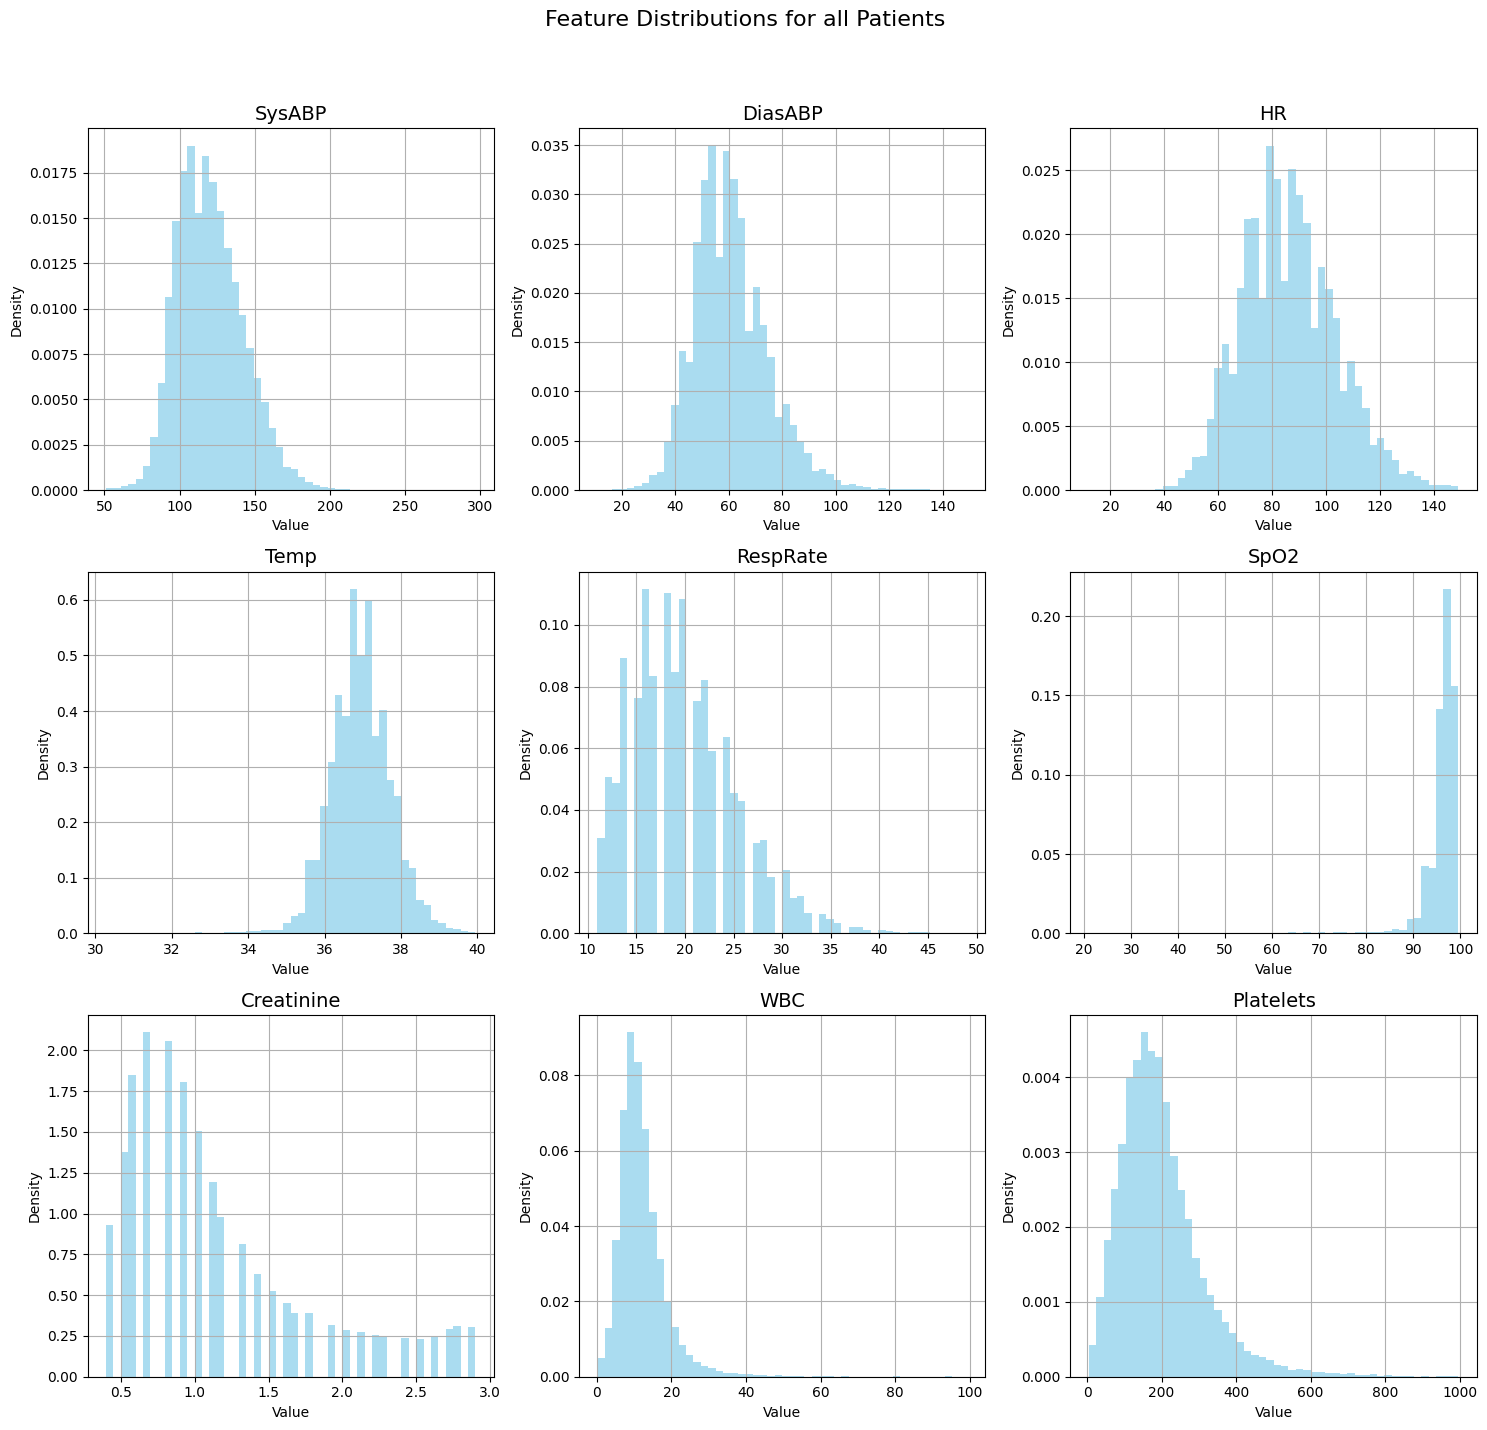

In [18]:
plot_feature_distribution_all_patients(all_padded_feature_matrices, enc['feature_matrix_row_names'], enc['feature_sampling_interval_minutes'])

In [ ]:
# Call the function to generate feature statistics
raw_feature_statistics_df = generate_feature_statistics_all_patients(all_padded_feature_matrices, enc['feature_matrix_row_names'], enc['feature_sampling_interval_minutes'])
print(raw_feature_statistics_df)

                  Mean     Median     Std Dev        Min        Max  \
SysABP      120.396417      118.0   21.837838       51.0      297.0   
DiasABP      60.858185       59.0   13.772755       11.0      149.0   
HR           86.393628       85.0    17.43871       12.0      149.0   
Temp         36.943526  36.944444    0.805375  30.277778  39.944445   
RespRate     19.837636       19.0    5.451005       11.0       49.0   
SpO2         96.028943       97.0    4.701311       21.0       99.6   
Creatinine     1.14551        0.9    0.632639        0.4        2.9   
WBC          12.083107       10.9     6.63008       0.14       99.2   
Platelets   198.566452      179.0  113.150209        5.0      996.0   

           25th Percentile 75th Percentile  
SysABP               104.0           134.0  
DiasABP               51.0            69.0  
HR                    74.0            98.0  
Temp             36.444444       37.444444  
RespRate              16.0            23.0  
SpO2               

# Exploring the Data

For the 3 features: 

    a. Systolic Blood Pressure (SysABP)

    b. Temperature (Temp) 

    c. White Blood Cell Count (WBC)
    
## TODOs:

1. Generate figures to describe the distribution of these features: ie their variability and central tendency. Make the figures as easy to read and self-explanatory as possible as if you were going to publish them. 

2. Look up each of these 3 features. Have you plotted a clinically plausible, ie physiologically distributed, spread of measurements that you would expect for each feature ? 

4. What are the units of measurement each feature likely uses ?

In [199]:
# Explore raw data
from datetime import datetime
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
%matplotlib inline

In [36]:
print(np.array(enc['feature_matrix'][0]).dtype)
print(np.array(enc['feature_matrix'][3]).dtype)
print(np.array(enc['feature_matrix'][7]).dtype)

float64
float64
float64


In [442]:
print(all_is_in_hospital.sum())
print(all_is_berlin_ards.sum())

2437
439


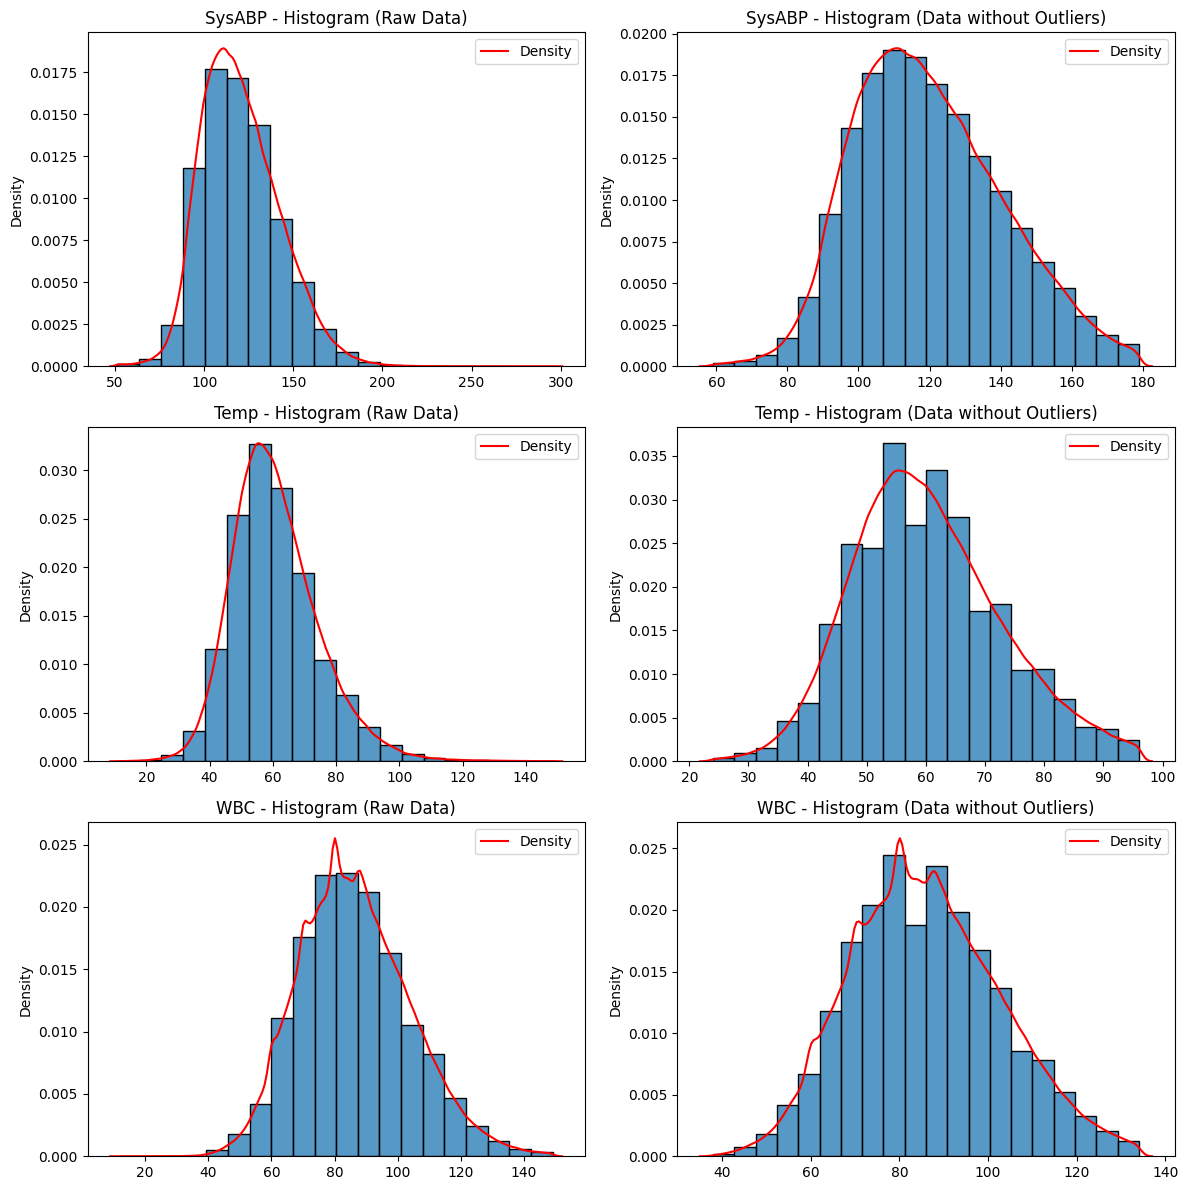

In [289]:
#### Distribution Overlay: Overlay the histograms of 'SysABP', 'Temp', and 'WBC' for patients with and without outliers. This plot can provide a visual comparison of the feature distributions between the two datasets.

# Select the features for the correlation matrix
selected_features = ['SysABP', 'Temp', 'WBC']

# Get the indices of the selected features in the feature list
feature_indices = [selected_features.index(feature) for feature in selected_features]


# Create a figure to display the histograms and density plots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Loop through each feature and plot the histograms and density plots
for i, (feature_name, feature_idx) in enumerate(zip(selected_features, feature_indices)):
    # Extract the data for the current feature
    data = all_padded_feature_matrices[:, feature_idx, :].flatten()
    
    # Remove NaN values from the data
    data = data[~np.isnan(data)]

    # Identify and exclude outliers using the IQR method
    def exclude_outliers(data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return data[(data >= lower_bound) & (data <= upper_bound)]

    data_no_outliers = exclude_outliers(data)

    # Plot the histogram with grouped bars for the raw data
    sns.histplot(data, kde=False, ax=axes[i, 0], bins=20, stat='density', common_norm=False)
    sns.kdeplot(data, ax=axes[i, 0], color='red', label='Density')
    axes[i, 0].set_title(f"{feature_name} - Histogram (Raw Data)")
    axes[i, 0].legend()

    # Plot the histogram with grouped bars for the data without outliers
    sns.histplot(data_no_outliers, kde=False, ax=axes[i, 1], bins=20, stat='density', common_norm=False)
    sns.kdeplot(data_no_outliers, ax=axes[i, 1], color='red', label='Density')
    axes[i, 1].set_title(f"{feature_name} - Histogram (Data without Outliers)")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


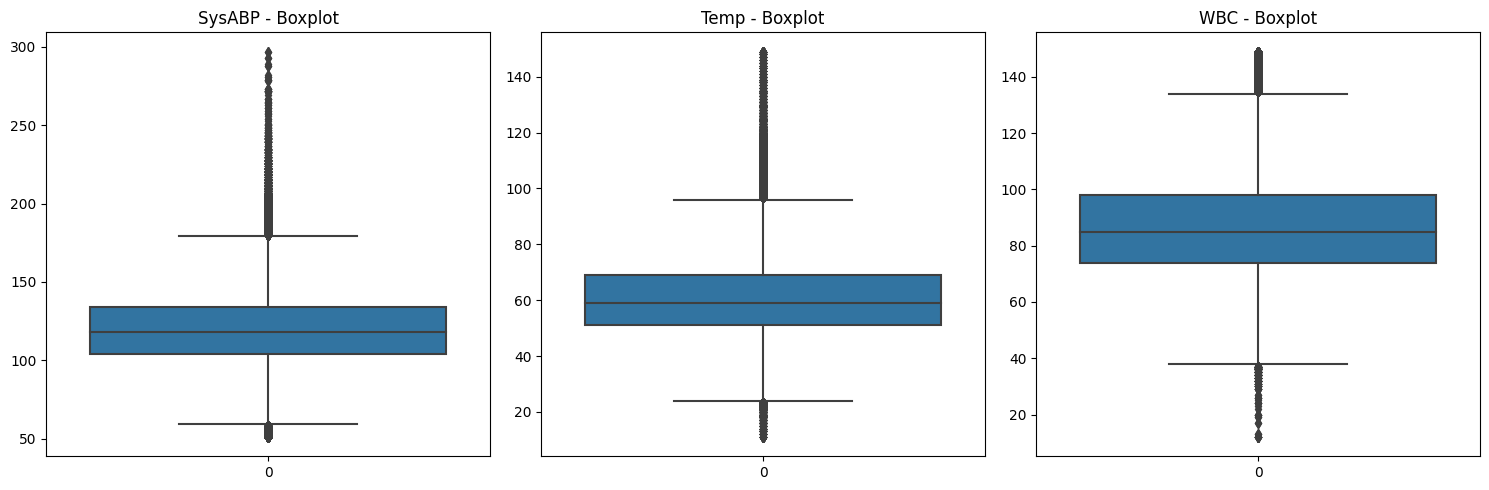

In [177]:
#### Boxplots for visualizing outliers. 

# Create a figure to display the boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each feature and plot the boxplots
for i, (feature_name, feature_idx) in enumerate(zip(selected_features, feature_indices)):
    # Extract the data for the current feature
    data = all_padded_feature_matrices[:, feature_idx, :].flatten()
    
    # Remove NaN values from the data
    data = data[~np.isnan(data)]

    # Create a boxplot to visualize outliers
    sns.boxplot(data=data, ax=axes[i])
    axes[i].set_title(f"{feature_name} - Boxplot")

plt.tight_layout()
plt.show()


In [ ]:
'''
Based on search resutls, normal Systolic Blood Pressure ranges from 90 to 120 mmHg, normal body temperature is around 37°C, and a typical White Blood Cell Count ranges from 4 to 11 x10^9/L. 
The presence of extremely low or high values may indicate missing data or outliers that need further investigation or data cleaning. Additionally, the spread and quartile values provide insights into the distribution of the data and the range of values observed in the patient population.
'''

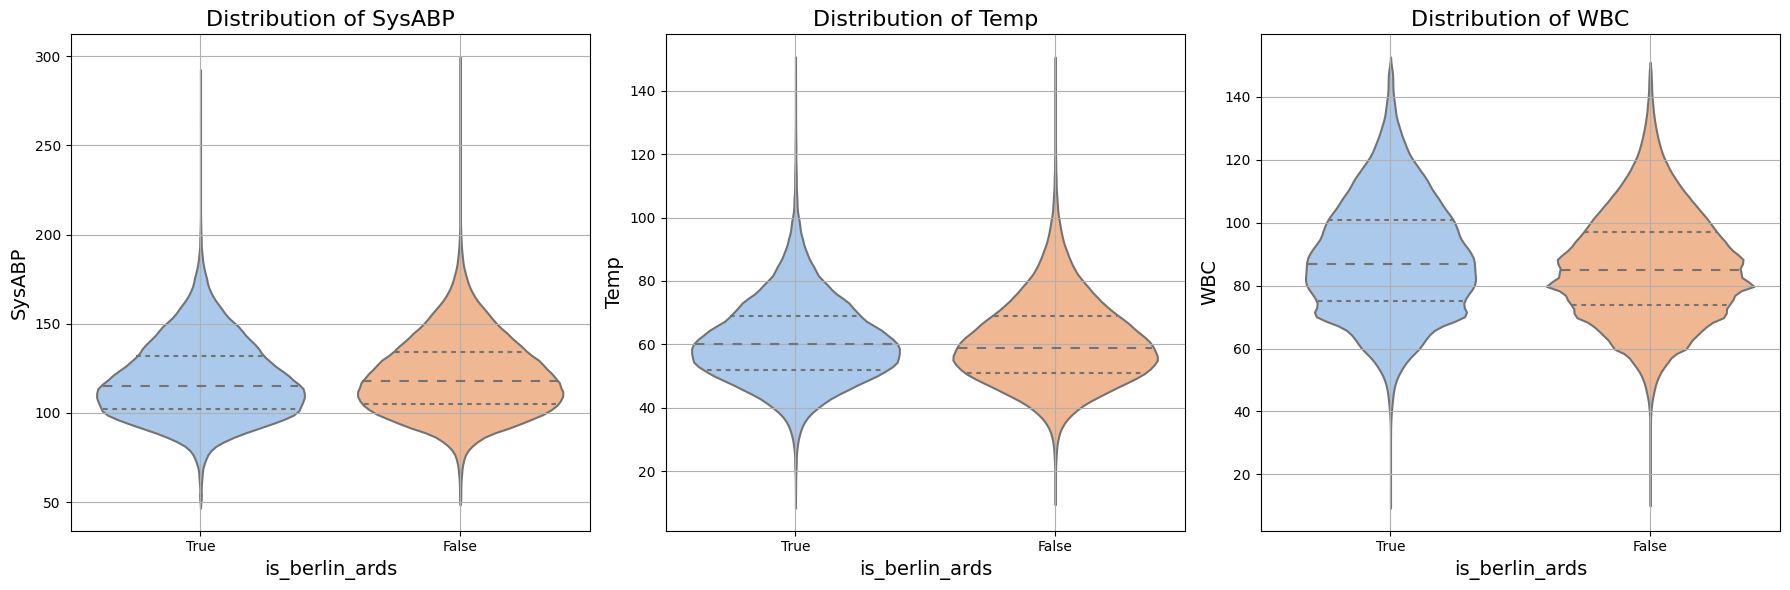

In [294]:
#### Violin plots to compare the distribution of the three features 'SysABP', 'Temp', and 'WBC' between patients with and without ARDS.

# Create subplots for each feature
fig, axes = plt.subplots(nrows=1, ncols=len(selected_features), figsize=(18, 6))

# Loop through each feature and create violin plots
for i, feature_name in enumerate(selected_features):
    # Filter the data for the specific feature and in-hospital death status
    data_true = all_padded_feature_matrices[all_is_berlin_ards]
    data_false = all_padded_feature_matrices[~all_is_berlin_ards]

    # Extract the feature data for the current feature
    data_true = data_true[:, i, :]
    data_false = data_false[:, i, :]

    # Flatten the 2D array to a 1D array
    data_true = data_true.ravel()
    data_false = data_false.ravel()

    # Combine the data into a single DataFrame for Seaborn
    data = pd.DataFrame({
        'is_berlin_ards': np.concatenate([np.full(len(data_true), 'True'), np.full(len(data_false), 'False')]),
        feature_name: np.concatenate([data_true, data_false])
    })

    # Create the violin plot
    sns.violinplot(x='is_berlin_ards', y=feature_name, data=data, ax=axes[i], palette='pastel', inner='quartile')
    axes[i].set_title(f'Distribution of {feature_name}', fontsize=16)
    axes[i].set_xlabel('is_berlin_ards', fontsize=14)
    axes[i].set_ylabel(f'{feature_name}', fontsize=14)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight
The figure layout has changed to tight


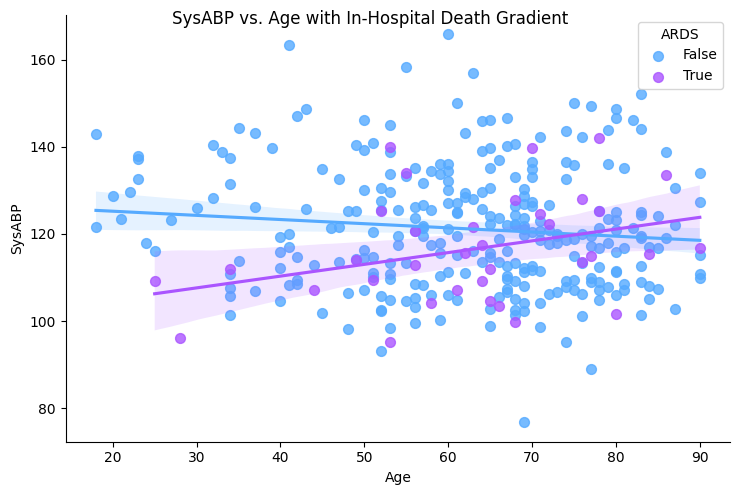

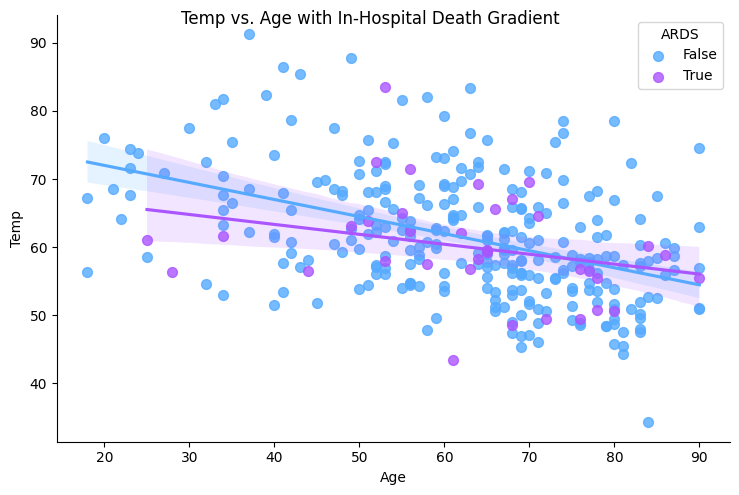

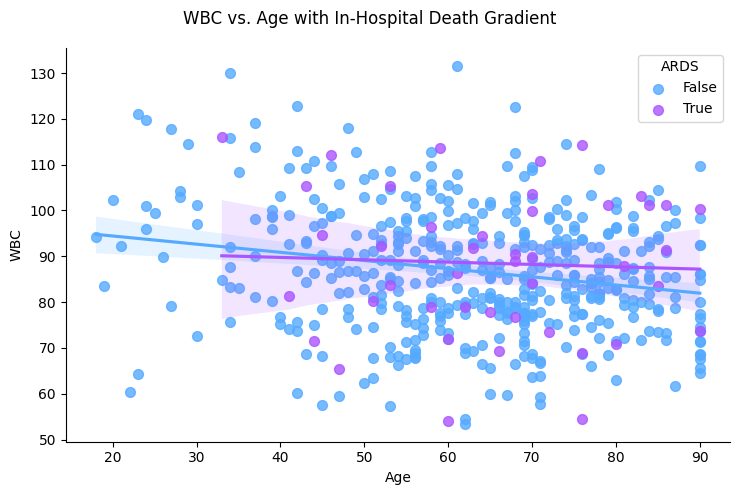

In [ ]:
#### Regression plots between 'SysABP', 'Temp', and 'WBC' and other continuous variables such as age, with color indicating the level of ARDS. This plot can reveal potential correlations between the selected features and other factors.

# Calculate the average feature values across time
average_feature_values = np.mean(all_padded_feature_matrices, axis=2)

# Plot the histogram with grouped bars for the raw data
for i, feature in enumerate(selected_features):
    # Extract average feature data
    feature_values = average_feature_values[:, i]
    
    # Extract age and ARDS data
    age_values = all_ages
    is_berlin_ards_values = all_is_berlin_ards
    
    # Create a DataFrame with the data for regression plot
    data_df = pd.DataFrame({
        'Age': age_values,
        'Feature': feature_values,
        'ARDS': is_berlin_ards_values
    })
    
    # Create a FacetGrid
    g = sns.FacetGrid(data_df, hue='ARDS', palette='cool', height=5, aspect=1.5)
    
    # Map lmplot onto the FacetGrid
    g.map(sns.regplot, 'Age', 'Feature', scatter_kws={'s': 50}, fit_reg=True)
    
    # Set labels and title for the plot
    g.set_axis_labels('Age', f'{feature}')
    g.fig.suptitle(f'{feature} vs. Age with In-Hospital Death Gradient')
    plt.legend(title='ARDS', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


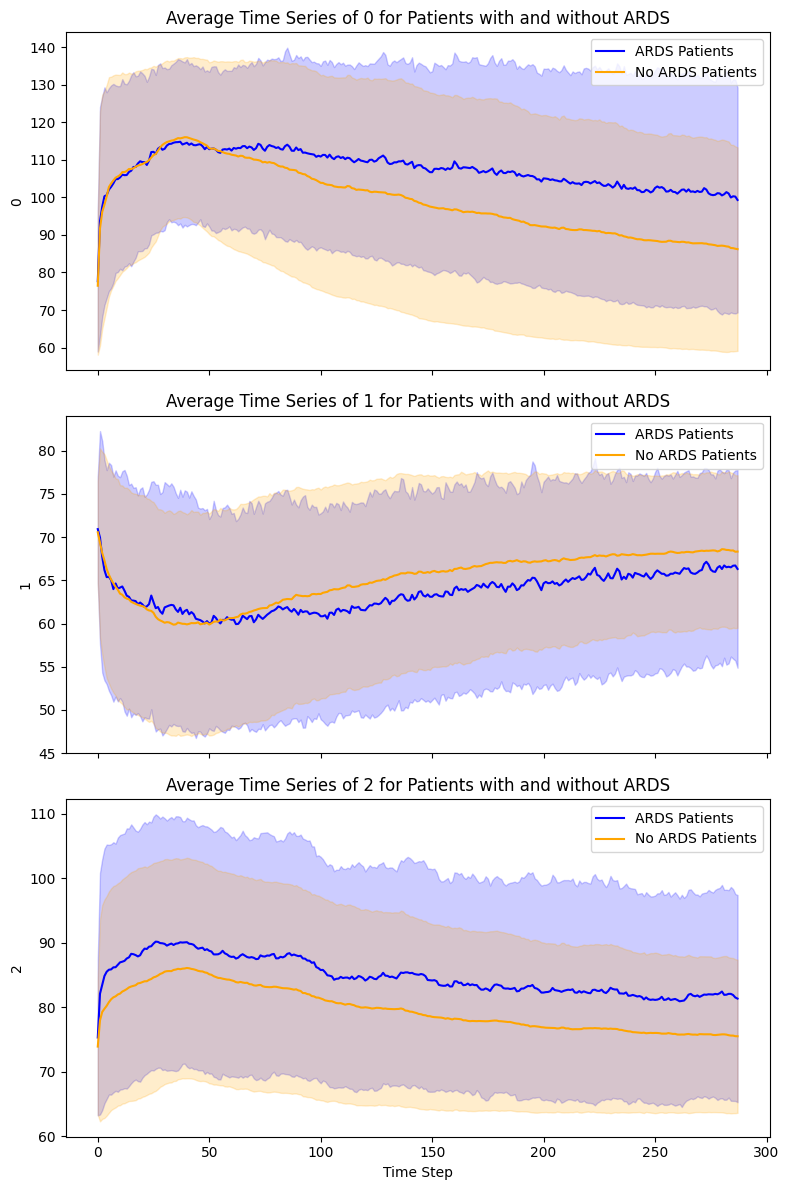

In [465]:
#### Line plots for 'SysABP', 'Temp', and 'WBC' for patients with and without ARDS over time. 

# Create separate feature matrices for patients with and without ARDS
patients_with_ards = all_padded_feature_matrices[all_is_berlin_ards]
patients_without_ards = all_padded_feature_matrices[~all_is_berlin_ards]

# Replace NaN values with the mean value in the feature matrices
patients_with_ards = np.nan_to_num(patients_with_ards, nan=np.nanmean(patients_with_ards))
patients_without_ards = np.nan_to_num(patients_without_ards, nan=np.nanmean(patients_without_ards))

# Calculate average and standard deviation time series for patients with and without ARDS
average_with_ards = np.mean(patients_with_ards, axis=0)
std_with_ards = np.std(patients_with_ards, axis=0)
average_without_ards = np.mean(patients_without_ards, axis=0)
std_without_ards = np.std(patients_without_ards, axis=0)

# Create three separate line plots for SysABP, Temp, and WBC
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

for i in range(3):
    # Plot patients with ARDS
    axes[i].plot(np.arange(average_with_ards.shape[1]), average_with_ards[i], label='ARDS Patients', color='blue')
    axes[i].fill_between(np.arange(average_with_ards.shape[1]), average_with_ards[i] - std_with_ards[i], average_with_ards[i] + std_with_ards[i], alpha=0.2, color='blue')

    # Plot patients without ARDS
    axes[i].plot(np.arange(average_without_ards.shape[1]), average_without_ards[i], label='No ARDS Patients', color='orange')
    axes[i].fill_between(np.arange(average_without_ards.shape[1]), average_without_ards[i] - std_without_ards[i], average_without_ards[i] + std_without_ards[i], alpha=0.2, color='orange')

    # Set labels and title for each plot
    axes[i].set_ylabel(selected_features[i])
    axes[i].set_title(f'Average Time Series of {selected_features[i]} for Patients with and without ARDS')
    axes[i].legend()

# Set common x-axis label
plt.xlabel('Time Step')

# Adjust layout
plt.tight_layout()
plt.show()


# Machine Learning

ARDS or [Acute respiratory distress syndrome](https://www.uptodate.com/contents/acute-respiratory-distress-syndrome-clinical-features-diagnosis-and-complications-in-adults) is a difficult disease both to define and also to predict. The definition of ARDS we will be using is the Berlin Criteria (Lung imaging shows Bilateral Infiltrates and PaO2/FiO2 is < 300). We are going to have you design and train an algorithm to predict the onset of ARDS before it occurs as best you can using the limited data in this sample dataset. The target labels are provided for you for each patient encounter, see below:

In [397]:
encounter_index = 1
print('Did this patient develope ARDS according to the Berlin Criteria?',
      berlin_ards[keys[encounter_index]]['Info']['is_Berlin_ARDS'])
print('Time Berlin Criteria was evaluated',
      berlin_ards[keys[encounter_index]]['Info']['is_Berlin_time'])

Did this patient develope ARDS according to the Berlin Criteria? False
Time Berlin Criteria was evaluated 2127-03-03T17:27:00


### Guidelines

a. You can choose which machine learning algorithm and python packages to use 

b. You can choose which features to use. 

c. Only use features as inputs to the algorithm that are available at or before the time you plan to make the prediction. You are free to choose a time that you want to make the prediction. If ARDS occurs 48 hours into the hospitalization and your machine learning algorithm makes a prediction at 24 hours into the hospitalization, make sure you are not using information from the dataset that becomes available only after 24 hours. 


## TODOs:

1. Set aside a portion of the encounters to use as the hold out test set.

2. Train and validate the algorithm on the remaining dataset.

2. Plot the area under the [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) aka AUC on the hold out test set. 

3. Generate a figure to help us understand how the algorithm makes it's decisions. ie address model interpretability.

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


### Attemtp 1: Here I start by training the data on the basic machine learning models.

In [14]:
#### WRITE CODE HERE #####

#### Step 1: Prepare Datasets

# Set aside a portion of encounters as the hold-out test set
encounter_indices = list(berlin_ards.keys())

# Exclude encounters with missing ARDS information
valid_encounter_indices = [i for i in encounter_indices if 'is_Berlin_ARDS' in berlin_ards[i]['Info']]

# Split the valid encounters into training and hold-out test sets
train_encounter_indices, test_encounter_indices = train_test_split(valid_encounter_indices, test_size=0.2, random_state=42)

# Check the number of encounters in each set
print(f"Number of encounters in training set: {len(train_encounter_indices)}")
print(f"Number of encounters in hold-out test set: {len(test_encounter_indices)}")


#### WRITE CODE HERE #####

Number of encounters in training set: 6967
Number of encounters in hold-out test set: 1742


In [ ]:
#### With the additional data such as age, weight, and gender. 
# Select the features
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
selected_feature_names = berlin_ards[keys[0]]['feature_matrix_row_names']
selected_feature_matrix = []

for encounter_id in valid_encounter_indices:
    feature_matrix_encounter = berlin_ards[encounter_id]['feature_matrix']
    # Select the features available within the first 24 hours.
    period = berlin_ards[encounter_id]['feature_sampling_interval_minutes']
    selected_features_encounter = np.array([feature_matrix_encounter[i][:int(24 * 60 / period)] for i in selected_features])
    
    # Get age, weight, and gender 
    age = berlin_ards[encounter_id]['Info']['age']
    weight = berlin_ards[encounter_id]['Info']['weight']
    gender = berlin_ards[encounter_id]['Info']['gender']
    
    # Reshape age, weight, and gender to match the second dimension of selected_features_encounter
    age = np.array(age).reshape(-1, 1)
    weight = np.array(weight).reshape(-1, 1)
    gender_encoded = np.array([1 if g == 'F' else 0 for g in gender]).reshape(-1, 1)
    
    # Repeat age, weight_encoded, and gender_encoded to match the shape of selected_features_encounter
    age_repeated = np.repeat(age, selected_features_encounter.shape[1], axis=1)
    weight_repeated = np.repeat(weight, selected_features_encounter.shape[1], axis=1)
    gender_repeated = np.repeat(gender_encoded, selected_features_encounter.shape[1], axis=1)
    
    # Concatenate the selected features with age, weight, and gender
    selected_features_encounter = np.concatenate([selected_features_encounter, age_repeated, weight_repeated, gender_repeated], axis=0)

    selected_feature_matrix.append(selected_features_encounter)

selected_feature_matrix = np.concatenate(selected_feature_matrix, axis=1).T

In [ ]:
# Convert encounter IDs to indices
train_indices = [valid_encounter_indices.index(encounter_id) for encounter_id in train_encounter_indices]
test_indices = [valid_encounter_indices.index(encounter_id) for encounter_id in test_encounter_indices]

# Prepare the data for training and testing
X_train = selected_feature_matrix[train_indices]
y_train = [berlin_ards[encounter_id]['Info']['is_Berlin_ARDS'] for encounter_id in train_encounter_indices]
y_train = np.array([1 if y == True else 0 for y in y_train])
X_test = selected_feature_matrix[test_indices]
y_test = [berlin_ards[encounter_id]['Info']['is_Berlin_ARDS'] for encounter_id in test_encounter_indices]
y_test = np.array([1 if y == True else 0 for y in y_test])

In [34]:
# Create an imputer to fill missing values with the mean
# I didn't complicate the situation by constructing another imputer for categorical data using "most_frequency" because there's no missing data for gender. 
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.fit_transform(X_test_imputed)

In [35]:
#### Step 2: Train and Validate the Models

# Initialize the classifiers
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
gb_clf = GradientBoostingClassifier(random_state=42)

# Create and train the models
rf_clf.fit(X_train_scaled, y_train)
lr_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)

# Train and validate the models using cross-validation
rf_cv_scores = cross_val_score(rf_clf, X_train_scaled, y_train, cv=5)
lr_cv_scores = cross_val_score(lr_clf, X_train_scaled, y_train, cv=5)
gb_cv_scores = cross_val_score(gb_clf, X_train_scaled, y_train, cv=5)

print("Random forest average cross-validation accuracy: {:.2f}".format(rf_cv_scores.mean()))
print("Logistic regression average cross-validation accuracy: {:.2f}".format(lr_cv_scores.mean()))
print("Gradient boosting average cross-validation accuracy: {:.2f}".format(gb_cv_scores.mean()))

Random forest average cross-validation accuracy: 0.93
Logistic regression average cross-validation accuracy: 0.95
Gradient boosting average cross-validation accuracy: 0.95


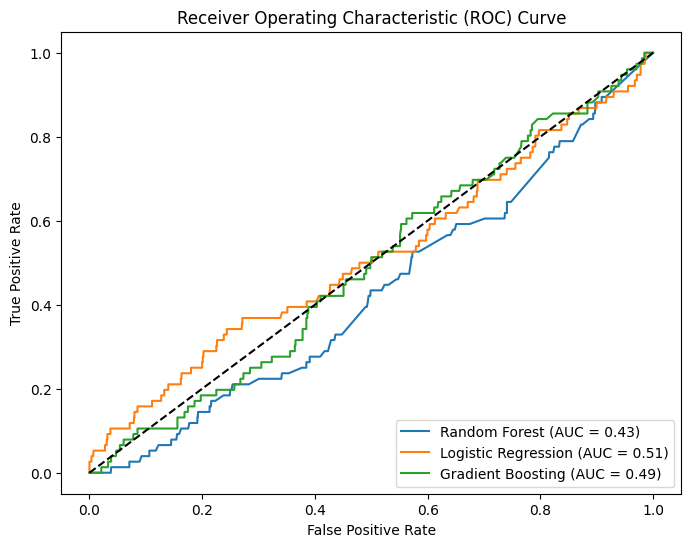

In [418]:
#### Step 3: Plot the Area Under the ROC Curve (AUC)

# Predict probabilities on the test set
rf_pred_probs = rf_clf.predict_proba(X_test_scaled)[:, 1]
lr_pred_probs = lr_clf.predict_proba(X_test_scaled)[:, 1]
gb_pred_probs = gb_clf.predict_proba(X_test_scaled)[:, 1]

# Calculate AUC scores
rf_auc = roc_auc_score(y_test, rf_pred_probs)
lr_auc = roc_auc_score(y_test, lr_pred_probs)
gb_auc = roc_auc_score(y_test, gb_pred_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, rf_pred_probs)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")

fpr, tpr, _ = roc_curve(y_test, lr_pred_probs)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")

fpr, tpr, _ = roc_curve(y_test, gb_pred_probs)
plt.plot(fpr, tpr, label=f"Gradient Boosting (AUC = {gb_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

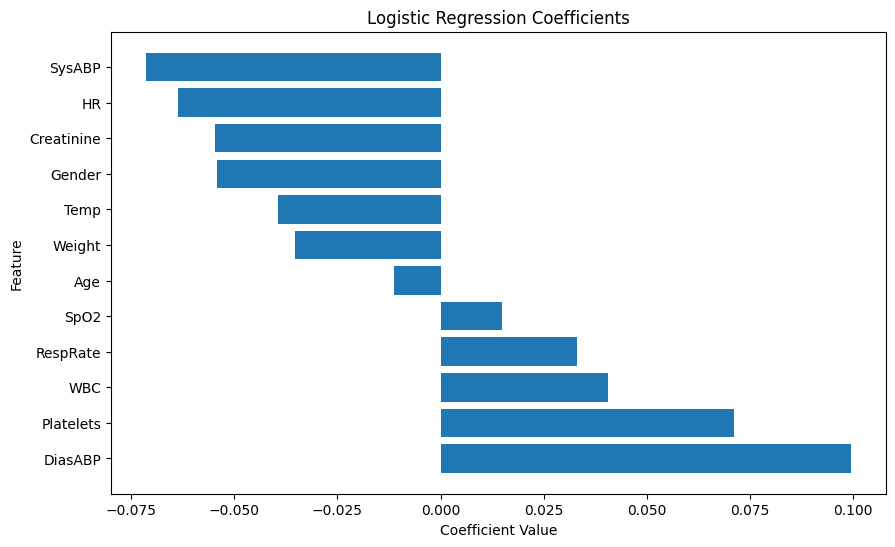

In [434]:
'''
Generate a figure for model interpretability: We will explore techniques to enhance the interpretability of the model's decision-making process.
'''
# Get the coefficients and corresponding feature names
coefficients = lr_clf.coef_[0]
feature_names = selected_feature_names.extend(['Age', 'Weight', 'Gender'])

# Sort the coefficients and feature names in descending order
sorted_indices = np.argsort(coefficients)[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a bar plot of the coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients")
plt.show()


In [443]:
# Evaluate the model on the hold-out test set
rf_accuracy = rf_clf.score(X_test_scaled, y_test)
lr_accuracy = lr_clf.score(X_test_scaled, y_test)
gb_accuracy = gb_clf.score(X_test_scaled, y_test)

print(f"Random forest accuracy on the hold-out test set: {rf_accuracy}")
print(f"Logistic regression accuracy on the hold-out test set: {lr_accuracy}")
print(f"Gradient boosting accuracy on the hold-out test set: {gb_accuracy}")

Random forest accuracy on the hold-out test set: 0.9414466130884042
Logistic regression accuracy on the hold-out test set: 0.9563719862227325
Gradient boosting accuracy on the hold-out test set: 0.9535017221584385


In [36]:
rf_y_pred = rf_clf.predict(X_test_scaled)
lr_y_pred = lr_clf.predict(X_test_scaled)
gb_y_pred = gb_clf.predict(X_test_scaled)

print("Random Forest \n", classification_report(y_test, rf_y_pred))
print("Logistic Regression \n", classification_report(y_test, lr_y_pred))
print("Gradient Boosting \n", classification_report(y_test, gb_y_pred))

Random Forest 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1666
           1       0.00      0.00      0.00        76

    accuracy                           0.94      1742
   macro avg       0.48      0.49      0.48      1742
weighted avg       0.91      0.94      0.93      1742

Logistic Regression 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1666
           1       0.00      0.00      0.00        76

    accuracy                           0.96      1742
   macro avg       0.48      0.50      0.49      1742
weighted avg       0.91      0.96      0.94      1742

Gradient Boosting 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1666
           1       0.00      0.00      0.00        76

    accuracy                           0.95      1742
   macro avg       0.48      0.50      0.49      1742
weighted avg    

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Attempt 2: Here I try neural network to see if we could improve the AUC score.

Epoch 1/10
196/196 [==============================] - 1s 2ms/step - loss: 0.2619 - accuracy: 0.9352 - val_loss: 0.1978 - val_accuracy: 0.9584
Epoch 2/10
196/196 [==============================] - 0s 1ms/step - loss: 0.2198 - accuracy: 0.9467 - val_loss: 0.1907 - val_accuracy: 0.9584
Epoch 3/10
196/196 [==============================] - 0s 1ms/step - loss: 0.2141 - accuracy: 0.9467 - val_loss: 0.1845 - val_accuracy: 0.9584
Epoch 4/10
196/196 [==============================] - 0s 1ms/step - loss: 0.2110 - accuracy: 0.9467 - val_loss: 0.1826 - val_accuracy: 0.9584
Epoch 5/10
196/196 [==============================] - 0s 1ms/step - loss: 0.2081 - accuracy: 0.9467 - val_loss: 0.1828 - val_accuracy: 0.9584
Epoch 6/10
196/196 [==============================] - 0s 1ms/step - loss: 0.2064 - accuracy: 0.9467 - val_loss: 0.1788 - val_accuracy: 0.9584
Epoch 7/10
196/196 [==============================] - 0s 1ms/step - loss: 0.2051 - accuracy: 0.9467 - val_loss: 0.1795 - val_accuracy: 0.9584
Epoch 

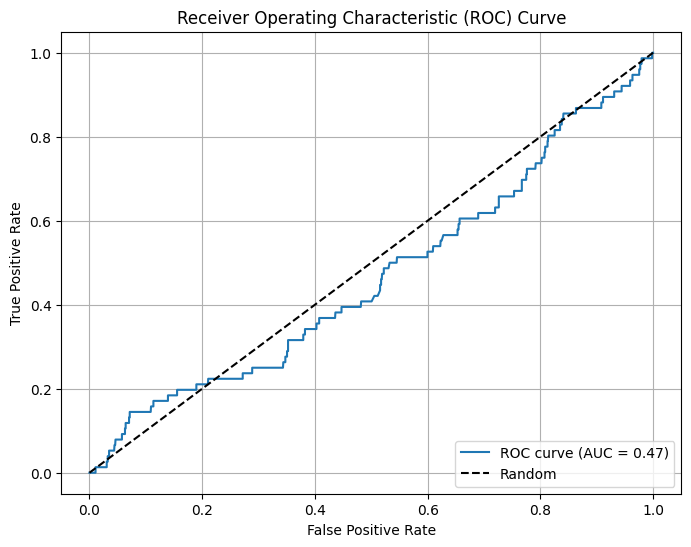

In [435]:
#### Build neural network model 

import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training set
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

# Print the results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Get predicted probabilities on the test set
y_pred_prob = model.predict(X_test_scaled).flatten()

# Calculate the area under the ROC curve
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the area under the ROC curve
print(f'Area under the ROC curve: {roc_auc:.4f}')

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Attempt 3: Here I try a different way of constructing the feature matrices to improve the AUC score.

In [50]:
#### Step 1: Data Preprocessing and Feature Engineering
#### V3: Reshape the features matrices in a different way than before. 

# Choose the number of timesteps to include in the dataset. 
num_timesteps_24_hours = 24 # Here we choose 24 hours. 
period = 30 # TODO: This could be done better by using all_time_intervals we computed earlier and apply that for each patient before concatenating. Since all the values are 30 here, we simply apply 30 here. 

# Select data for the first 24 hours (first 48 timesteps) for each patient
all_padded_feature_matrices_24_hours = all_padded_feature_matrices[:, :, :int(num_timesteps_24_hours * 60 / period)]

# Select relevant features and labels
selected_features = ['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets', 'age', 'weight']
X = all_padded_feature_matrices_24_hours
y = all_is_berlin_ards

# Expand all_ages and all_weights to have the same time dimension as all_feature_matrices
expanded_all_ages = np.tile(all_ages[:, np.newaxis, np.newaxis], (1, 1, X.shape[2]))
expanded_all_weights = np.tile(all_weights[:, np.newaxis, np.newaxis], (1, 1, X.shape[2]))

# Concatenate features
X = np.concatenate([X, expanded_all_ages, expanded_all_weights], axis=1)

# Reshape X into a 2D array
X = X.reshape(X.shape[0], -1)

In [51]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# One-hot encode categorical data (if 'gender' is a categorical feature)
# Assuming gender is a categorical feature
gender_encoded = OneHotEncoder().fit_transform(all_genders.reshape(-1, 1)).toarray()
X = np.concatenate([X, gender_encoded], axis=1)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6967, 530)
(1742, 530)
(6967,)
(1742,)


In [283]:
#### Step 2: Train and Validate the Models

# Initialize the classifiers
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
gb_clf = GradientBoostingClassifier(random_state=42)

# Train and validate the models using cross-validation
rf_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='roc_auc')
lr_scores = cross_val_score(lr_clf, X_train, y_train, cv=5, scoring='roc_auc')
gb_scores = cross_val_score(gb_clf, X_train, y_train, cv=5, scoring='roc_auc')

print("Random Forest AUC scores:", rf_scores)
print("Logistic Regression AUC scores:", lr_scores)
print("Gradient Boosting AUC scores:", gb_scores)


Random Forest AUC scores: [0.6630614  0.68391007 0.67751178 0.72525023 0.66757472]
Logistic Regression AUC scores: [0.53631018 0.65428847 0.65319833 0.59081924 0.62464716]
Gradient Boosting AUC scores: [0.65021829 0.67293872 0.73269409 0.71029944 0.70770548]


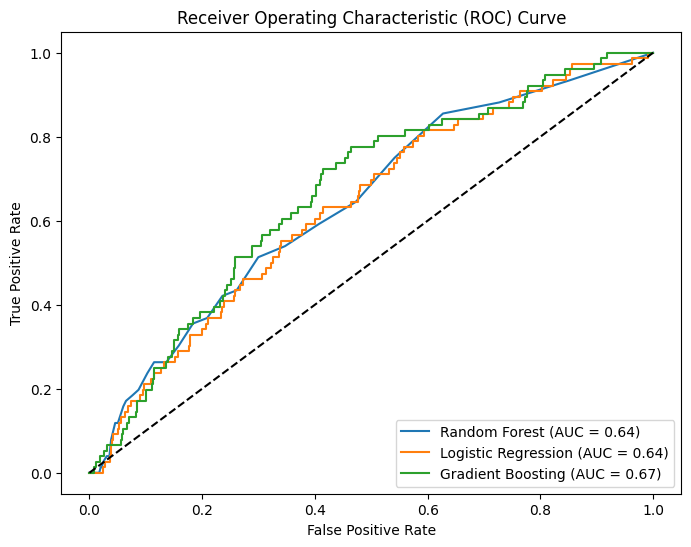

In [284]:
#### Step 3: Plot the Area Under the ROC Curve (AUC)

# Fit the models on the training data
rf_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)

# Predict probabilities on the test set
rf_pred_probs = rf_clf.predict_proba(X_test)[:, 1]
lr_pred_probs = lr_clf.predict_proba(X_test)[:, 1]
gb_pred_probs = gb_clf.predict_proba(X_test)[:, 1]

# Calculate AUC scores
rf_auc = roc_auc_score(y_test, rf_pred_probs)
lr_auc = roc_auc_score(y_test, lr_pred_probs)
gb_auc = roc_auc_score(y_test, gb_pred_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, rf_pred_probs)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")

fpr, tpr, _ = roc_curve(y_test, lr_pred_probs)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")

fpr, tpr, _ = roc_curve(y_test, gb_pred_probs)
plt.plot(fpr, tpr, label=f"Gradient Boosting (AUC = {gb_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Epoch 1/50
175/175 [==============================] - 1s 3ms/step - loss: 0.2601 - accuracy: 0.9306 - val_loss: 0.1940 - val_accuracy: 0.9584
Epoch 2/50
175/175 [==============================] - 0s 2ms/step - loss: 0.1889 - accuracy: 0.9455 - val_loss: 0.1985 - val_accuracy: 0.9562
Epoch 3/50
175/175 [==============================] - 0s 2ms/step - loss: 0.1643 - accuracy: 0.9472 - val_loss: 0.2038 - val_accuracy: 0.9491
Epoch 4/50
175/175 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9510 - val_loss: 0.2103 - val_accuracy: 0.9519
Epoch 5/50
175/175 [==============================] - 0s 2ms/step - loss: 0.1222 - accuracy: 0.9559 - val_loss: 0.2213 - val_accuracy: 0.9519
Epoch 6/50
175/175 [==============================] - 0s 2ms/step - loss: 0.1038 - accuracy: 0.9641 - val_loss: 0.2337 - val_accuracy: 0.9519


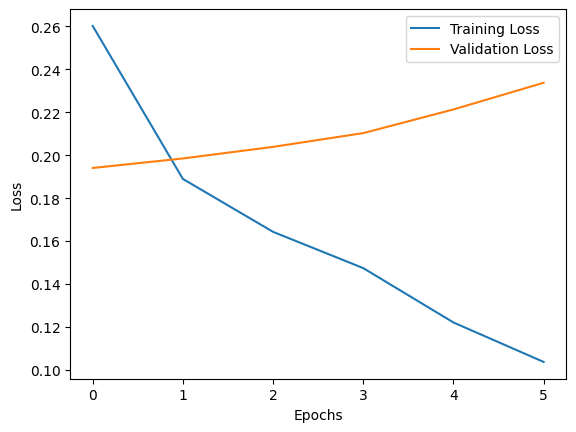

In [360]:
#### Step 2: Train and Validate the Neural Network Model

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Build the neural network model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


55/55 [==============================] - 0s 1ms/step


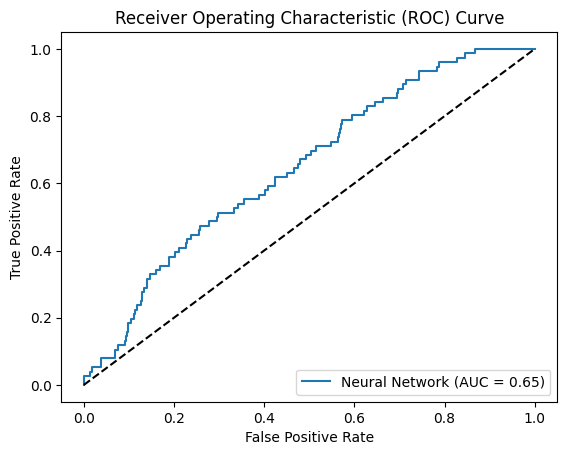

In [361]:
# TODO: Fix this plot by adding it to the plot with other models for comparative purposes. 

#### Step 3: Evaluate the Neural Network Model

from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities on the test set
y_pred_probs = model.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_probs)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f'Neural Network (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



### Attempt 4: Here I tried to resample the data and train again to handle the problem of imbalanced dataset. 

In [54]:
import numpy as np
from imblearn.over_sampling import SMOTE

# Convert selected_feature_matrix to a numpy array
X_imbalance = X

# Replace missing values (NaN) with the mean of each feature
imputer = SimpleImputer(strategy='mean')
selected_feature_matrix_imputed = imputer.fit_transform(X_imbalance)

# Create the target labels for each encounter (1 for ARDS, 0 for no ARDS)
target_labels = [1 if berlin_ards[encounter_id]['Info']['is_Berlin_ARDS'] else 0 for encounter_id in valid_encounter_indices]
target_labels = np.array(target_labels)

# Print the class distribution before applying SMOTE
print("Class distribution before SMOTE:", np.bincount(target_labels))

# Apply SMOTE to oversample the minority class (ARDS)
smote = SMOTE(sampling_strategy='auto', random_state=42)
selected_feature_matrix_resampled, target_labels_resampled = smote.fit_resample(selected_feature_matrix_imputed, target_labels)

# Print the class distribution after applying SMOTE
print("Class distribution after SMOTE:", np.bincount(target_labels_resampled))

Class distribution before SMOTE: [8270  439]
Class distribution after SMOTE: [8270 8270]


In [60]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(selected_feature_matrix_resampled, target_labels_resampled, test_size=0.2, random_state=42)

In [61]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13232, 530)
(3308, 530)
(13232,)
(3308,)


In [63]:
#### Step 2: Train and Validate the Models

# Initialize the classifiers
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
gb_clf = GradientBoostingClassifier(random_state=42)

# Train and validate the models using cross-validation
rf_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='roc_auc')
lr_scores = cross_val_score(lr_clf, X_train, y_train, cv=5, scoring='roc_auc')
gb_scores = cross_val_score(gb_clf, X_train, y_train, cv=5, scoring='roc_auc')

print("Random Forest AUC scores:", rf_scores)
print("Logistic Regression AUC scores:", lr_scores)
print("Gradient Boosting AUC scores:", gb_scores)


Random Forest AUC scores: [0.99528474 0.99509577 0.99725994 0.9968186  0.99681174]
Logistic Regression AUC scores: [0.83135748 0.8176253  0.8212776  0.84330366 0.84927111]
Gradient Boosting AUC scores: [0.98197587 0.98739704 0.9863837  0.98980134 0.98487541]


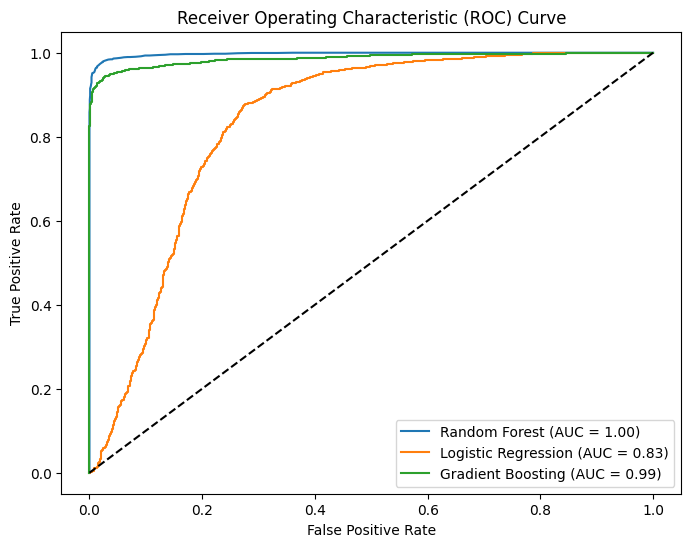

In [64]:
#### Step 3: Plot the Area Under the ROC Curve (AUC)

# Fit the models on the training data
rf_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)

# Predict probabilities on the test set
rf_pred_probs = rf_clf.predict_proba(X_test)[:, 1]
lr_pred_probs = lr_clf.predict_proba(X_test)[:, 1]
gb_pred_probs = gb_clf.predict_proba(X_test)[:, 1]

# Calculate AUC scores
rf_auc = roc_auc_score(y_test, rf_pred_probs)
lr_auc = roc_auc_score(y_test, lr_pred_probs)
gb_auc = roc_auc_score(y_test, gb_pred_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, rf_pred_probs)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")

fpr, tpr, _ = roc_curve(y_test, lr_pred_probs)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")

fpr, tpr, _ = roc_curve(y_test, gb_pred_probs)
plt.plot(fpr, tpr, label=f"Gradient Boosting (AUC = {gb_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [65]:
rf_y_pred = rf_clf.predict(X_test)
lr_y_pred = lr_clf.predict(X_test)
gb_y_pred = gb_clf.predict(X_test)

print("Random Forest \n", classification_report(y_test, rf_y_pred))
print("Logistic Regression \n", classification_report(y_test, lr_y_pred))
print("Gradient Boosting \n", classification_report(y_test, gb_y_pred))

Random Forest 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1651
           1       0.98      0.98      0.98      1657

    accuracy                           0.98      3308
   macro avg       0.98      0.98      0.98      3308
weighted avg       0.98      0.98      0.98      3308

Logistic Regression 
               precision    recall  f1-score   support

           0       0.82      0.75      0.78      1651
           1       0.77      0.83      0.80      1657

    accuracy                           0.79      3308
   macro avg       0.79      0.79      0.79      3308
weighted avg       0.79      0.79      0.79      3308

Gradient Boosting 
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1651
           1       0.96      0.95      0.95      1657

    accuracy                           0.95      3308
   macro avg       0.95      0.95      0.95      3308
weighted avg    

### TODO List:

1. Resampling the Dataset:
   a. Oversampling: Increase the number of instances in the minority class (ARDS) by duplicating existing samples or generating synthetic samples (e.g., using SMOTE - Synthetic Minority Over-sampling Technique).
   b. Undersampling: Reduce the number of instances in the majority class (no ARDS) to balance the dataset. However, be cautious with this approach as you may lose important information.

2. Feature Engineering:
   a. Create features that capture specific patterns (e.g., spikes) in the time series data at specific time points.
   b. Utilize domain knowledge and medical insights to engineer relevant features that may be indicative of ARDS onset.

3. Improved Model for Time Series Data:
   a. Choose machine learning models that are well-suited for time series data, such as recurrent neural networks (RNNs) or long short-term memory (LSTM) networks.
   b. Explore time series-specific techniques, such as sliding windows or time-based cross-validation, to better capture temporal patterns and trends in the data.

4. Handling Patient Data Before 24 Hours:
   a. Exclude patients who have died before the first 24 hours of data from the model training process to avoid introducing biases and unrealistic predictions.
   b. Set a criterion to ensure that data from patients with less than 24 hours of information is not used for model fitting.

5. Model Interpretability:
   a. Utilize SHAP (SHapley Additive exPlanations) or other model-agnostic interpretability techniques to understand feature importances and the decision-making process of the model.
   b. Generate visualizations, such as SHAP summary plots, to help interpret the model's predictions and identify the most influential features.

6. Model Improvement and Iteration:
   a. Refine the model by incorporating feature selection techniques to focus on the most relevant features.
   b. Iterate on the feature engineering process based on insights from model interpretability and domain knowledge.

# Open Ended Creative Section

Teach us how to do a portion of a project you worked on recently and really enjoyed. It doesn't have to be medically or supervised learning related. It just has to be in the realm of data science. 

You can use the space below to display or generate visuals, write pseudocode, do math in $Late^X$ or take us through some demo code

### Project Overview
We want to build a platform for simulating entire animals and their brains in silico, with the assumption that we’ll be able to do the same kind of neuroscience we do in vivo, but faster, more flexibly and with mechanisms for adding varying degrees of biological realism. 
- Predict outcomes of experiments before we do them so that we can be more efficient about which ones will be the most useful. 
- Iterative error correction so we can always be consistent with the empirical evidence without reinventing the theory behind the models. 
- Flexible to incorporate any species, behavior, neural system, or level of biological detail. 


In [ ]:
"""Launch MOMPO agent on the control suite via Launchpad."""

import functools
from typing import Dict, Sequence, Tuple
from absl import app
from absl import flags
from acme import specs
from acme import types

# from acme.agents.tf import mompo
import helpers
from acme.tf import networks
from acme.tf import utils as tf2_utils
import launchpad as lp
import numpy as np
import sonnet as snt
import tensorflow as tf
from dm_control import suite
from acme import wrappers
from acme.utils import lp_utils
from virtualneurolab.tasks import rodent
from dm_control.utils import containers
from algorithms.mompo.agent_distributed import DistributedMultiObjectiveMPO
from algorithms.mompo.learning import RewardObjective, QValueObjective
from virtualneurolab.tasks.rodent import (
    go_to_target,
    rodent_mocap_tracking,
    bowl_escape,
    hop_gaps,
    rodent_run,
)

import random
import logger
from pathlib import Path
from cfg import parse_cfg

__CONFIG__, __LOGS__ = "cfgs", "logs"

suite._DOMAINS["rodent"] = rodent
SUITE = containers.TaggedTasks()


# Flags which modify the behavior of the launcher.
FLAGS = flags.FLAGS
_MAX_ACTOR_STEPS = flags.DEFINE_integer(
    "max_actor_steps",
    None,
    "Number of actor steps to run; defaults to None for an endless loop.",
)
_NUM_ACTORS = flags.DEFINE_integer("num_actors", 4, "Number of actors.")
# Flags for configuring the environment.
_DOMAIN = flags.DEFINE_string("domain", "cartpole", "Control suite domain name.")
_TASK = flags.DEFINE_string("task", "balance", "Control suite task name.")
_CONTACT_TERMINATION = flags.DEFINE_bool(
    "contact_termination", False, "Contact termination."
)


# # TODO: check the correct way to set seed in tensorflow.
# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
#     tf.experimental.numpy.random.seed(seed)
#     tf.set_random_seed(seed)


def make_networks(
    action_spec: specs.BoundedArray,
    num_critic_heads: int,
    policy_layer_sizes: Sequence[int] = (256, 256, 256),
    critic_layer_sizes: Sequence[int] = (512, 512, 256),
    num_layers_shared: int = 1,
    distributional_critic: bool = True,
    vmin: float = -150.0,
    vmax: float = 150.0,
    num_atoms: int = 51,
) -> Dict[str, types.TensorTransformation]:
    """Creates networks used by the agent."""

    num_dimensions = np.prod(action_spec.shape, dtype=int)

    policy_network = snt.Sequential(
        [
            networks.LayerNormMLP(policy_layer_sizes, activate_final=True),
            networks.MultivariateNormalDiagHead(
                num_dimensions, tanh_mean=False, init_scale=0.69
            ),
        ]
    )

    if not distributional_critic:
        critic_layer_sizes = list(critic_layer_sizes) + [1]

    if not num_layers_shared:
        # No layers are shared
        critic_network_base = None
    else:
        critic_network_base = networks.LayerNormMLP(
            critic_layer_sizes[:num_layers_shared], activate_final=True
        )
    critic_network_heads = [
        snt.nets.MLP(critic_layer_sizes, activation=tf.nn.elu, activate_final=False)
        for _ in range(num_critic_heads)
    ]
    if distributional_critic:
        critic_network_heads = [
            snt.Sequential([c, networks.DiscreteValuedHead(vmin, vmax, num_atoms)])
            for c in critic_network_heads
        ]
    # The multiplexer concatenates the (maybe transformed) observations/actions.
    critic_network = snt.Sequential(
        [
            networks.CriticMultiplexer(
                critic_network=critic_network_base,
                action_network=networks.ClipToSpec(action_spec),
            ),
            networks.Multihead(network_heads=critic_network_heads),
        ]
    )

    return {
        "policy": policy_network,
        "critic": critic_network,
        "observation": tf2_utils.batch_concat,
    }


def compute_action_norm(
    target_pi_samples: tf.Tensor, target_q_target_pi_samples: tf.Tensor
) -> tf.Tensor:
    """Compute Q-values for the action norm objective from action samples."""
    del target_q_target_pi_samples
    action_norm = tf.norm(target_pi_samples, ord=2, axis=-1)
    return tf.stop_gradient(-1 * action_norm)


def task_reward_fn(
    observation: tf.Tensor, action: tf.Tensor, reward: tf.Tensor
) -> tf.Tensor:
    del observation, action
    return tf.stop_gradient(reward)


def make_objectives() -> Tuple[Sequence[RewardObjective], Sequence[QValueObjective]]:
    """Define the multiple objectives for the policy to learn."""
    task_reward = RewardObjective(name="task", reward_fn=task_reward_fn)
    action_norm = QValueObjective(name="action_norm_q", qvalue_fn=compute_action_norm)
    return [task_reward], [action_norm]


def train(cfg):
    domain = cfg.task.replace("-", "_").split("_", 1)[0]
    domain = dict(cup="ball_in_cup").get(
        domain, domain
    )  # TODO: Figure out what this line is for.
    task = cfg.task.replace("-", "_")

    # Configure the environment factory with requested task.
    make_environment = functools.partial(
        helpers.make_environment,
        domain_name=domain,
        task_name=task,
        # task_kwargs={'contact_termination': _CONTACT_TERMINATION.value},
    )

    reward_objectives, qvalue_objectives = make_objectives()

    network_factory = lp_utils.partial_kwargs(
        make_networks, distributional_critic=True
    )  # TODO: try out vanilla_critics

    # # Construct the program.
    # program_builder = mompo.DistributedMultiObjectiveMPO(
    #     reward_objectives,
    #     qvalue_objectives,
    #     environment_factory=make_environment,
    #     network_factory=network_factory,
    #     target_policy_update_period=25,  # TODO: try out different values
    #     max_actor_steps=_MAX_ACTOR_STEPS.value,
    #     num_actors=_NUM_ACTORS.value,
    # )

    program_builder = DistributedMultiObjectiveMPO(
        reward_objectives,
        qvalue_objectives,
        environment_factory=make_environment,
        network_factory=network_factory,
        # target_policy_update_period=25,  # TODO: try out different values
        n_step=3,
        max_actor_steps=None,  # TODO: change to default cfg
        num_actors=4,  # TODO: change to default cfg
    )

    # Launch experiment.
    lp.launch(programs=program_builder.build())


if __name__ == "__main__":
    app.run(train(parse_cfg(Path.home().joinpath("projects", "neuroai") / __CONFIG__)))

In [ ]:
from IPython.display import HTML

# Specify the path to the HTML file
html_file_path = '../Projects/neuroai.html'

# Read the contents of the HTML file
with open(html_file_path, 'r') as file:
    html_contents = file.read()

# Display the HTML content
HTML(html_contents)